# 1. Imports

In [91]:
import numpy as np
from math import pi

import seaborn as sn
import pandas as pd

In [62]:
from tensorflow.keras.models import load_model

In [63]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [64]:
!pip install adversarial-robustness-toolbox

In [65]:
from art import *

from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

from matplotlib import pyplot as plt

import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import tensorflow as tf

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Load properties from another python file
from properties import *

In [66]:
from random import random, randint

# 2. Load models

In [67]:
path_model = "/content/ACASXU_1_1.h5"

In [68]:
model_11 = load_model(path_model)

In [69]:
model_11.compile()

In [70]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_11.predict(pt)

array([[0.19883643, 0.20087564, 0.19964513, 0.20093843, 0.19970441]],
      dtype=float32)

In [71]:
ACAS_model = model_11

# 3. Carlini & Wagner = CW

In [45]:
x_test = 0.8*np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1, 5)
print(x_test.shape)
print(x_test)
print(x_test.ndim)

(1, 5)
[[0.8 0.8 0.8 0.8 0.8]]
2


In [46]:
ACAS_classifier = TensorFlowV2Classifier(
    model=ACAS_model,
    loss_object=MSE,
    train_step=None,
    nb_classes=5,
    input_shape=(1, 5),
    clip_values=(-1.0, 1.0),
)

In [47]:
attack_Shadow = ShadowAttack(estimator=ACAS_classifier, 
                             lambda_tv=0.3, 
                             sigma=0.8, 
                             nb_steps=10,
                             verbose=True)

x_adv_shadow = attack_Shadow.generate(x_test) #, y=np.array([[0,1,0,0,0]]))

print(x_adv_shadow.shape)
print(x_adv_shadow)

ValueError: ignored

In [72]:
attack_NF = NewtonFool(classifier=ACAS_classifier, 
                       eta=0.95, 
                       max_iter = 20,
                       verbose=True)

x_adv_nf = attack_NF.generate(x_test) #, y=np.array([[0,1,0,0,0]]))

print(x_adv_nf.shape)
print(x_adv_nf)

NewtonFool:   0%|          | 0/1 [00:00<?, ?it/s]

(1, 5)
[[0.6790788 0.3252571 0.9147245 0.7498163 0.803792 ]]


In [73]:
model_11.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 50)                300       
                                                                 
 activation_98 (Activation)  (None, 50)                0         
                                                                 
 dense_99 (Dense)            (None, 50)                2550      
                                                                 
 activation_99 (Activation)  (None, 50)                0         
                                                                 
 dense_100 (Dense)           (None, 50)                2550      
                                                                 
 activation_100 (Activation)  (None, 50)               0         
                                                                 
 dense_101 (Dense)           (None, 50)              

# 4. Generate points

In [ ]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [ ]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [ ]:
x_test = random_main_pts(1000, X_dom)

In [ ]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [ ]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [ ]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [ ]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [ ]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [ ]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

(0, 5)


In [ ]:
Pcheck.shape

(1000000, 2)

# Try FGSM & CW

In [93]:
original_pts = np.random.rand(200, 5) # random_main_pts(10, X_dom)

In [75]:
print(original_pts)

[[0.64503868 0.22517846 0.27345505 0.18576205 0.99734877]
 [0.72422036 0.23993736 0.44570044 0.00625824 0.08875024]
 [0.75587775 0.8131253  0.05906341 0.21066995 0.90795945]
 [0.1543939  0.62929757 0.71010121 0.15883728 0.65933197]
 [0.16126769 0.08161742 0.73602627 0.72717183 0.48131994]
 [0.82536247 0.33551887 0.76086962 0.19033041 0.65826751]
 [0.20799342 0.14322862 0.92544188 0.00410809 0.98799024]
 [0.40924941 0.95484662 0.57354856 0.43402597 0.1493754 ]
 [0.00143467 0.09299703 0.09148635 0.22753118 0.79730955]
 [0.21850713 0.42806202 0.89302113 0.9552131  0.78642203]]


In [94]:
adv_pts_nf = attack_NF.generate(original_pts)

NewtonFool:   0%|          | 0/200 [00:00<?, ?it/s]

In [77]:
print("NF")
print(adv_pts_nf)


NF
[[ 0.6120344   0.31750807  0.06566731  0.19372164  0.9589168 ]
 [ 0.63566756  0.23545824  0.2616458  -0.1188745   0.18310514]
 [ 0.601638    0.405261    0.24697585  0.17026766  0.9154741 ]
 [-0.07043315  0.7073687   0.8543074   0.00230985  0.5851023 ]
 [ 0.06155502 -0.05641579  0.5702279   0.6942413   0.5245631 ]
 [ 0.731361    0.27424332  0.5833579   0.21820669  0.64795494]
 [ 0.12496914  0.13983122  0.93749195  0.02403916  0.9968333 ]
 [ 0.36185792  1.          0.29424927  0.38087067  0.21732081]
 [-0.01689305  0.10361274  0.05706991  0.0100699   0.87246776]
 [ 0.22660385  0.21254632  1.          0.9539991   0.7443011 ]]


In [95]:
original_pred = ACAS_model.predict(original_pts)

adv_pred_nf = ACAS_model.predict(adv_pts_nf)

In [79]:
print("Original pred :")
print(original_pred)

print("NF pred :")
print(adv_pred_nf)

Original pred :
[[0.19952835 0.2001324  0.20011587 0.20011467 0.20010875]
 [0.1995361  0.20012967 0.20011392 0.200113   0.20010738]
 [0.19954208 0.20012926 0.20011118 0.20010895 0.20010865]
 [0.19951637 0.20013674 0.20011881 0.20011702 0.20011105]
 [0.19932513 0.2075909  0.1948749  0.20957328 0.18863587]
 [0.19950749 0.200138   0.20012245 0.20012206 0.20011005]
 [0.2003104  0.19976981 0.20236728 0.19380067 0.20375185]
 [0.19867967 0.20112297 0.19944005 0.20121187 0.19954544]
 [0.19961755 0.20010535 0.20009002 0.20008808 0.20009896]
 [0.1995301  0.20013154 0.20011559 0.20011464 0.20010811]]
NF pred :
[[0.19956148 0.20012274 0.20010598 0.20010415 0.20010565]
 [0.19956382 0.2001216  0.20010565 0.20010419 0.20010479]
 [0.19953999 0.2001294  0.20011213 0.20011033 0.2001082 ]
 [0.19956984 0.20012017 0.20010363 0.20010176 0.20010467]
 [0.19936986 0.2000503  0.20025402 0.2        0.20032585]
 [0.1995198  0.2001347  0.20011856 0.20011768 0.20010929]
 [0.20155154 0.20030627 0.20075032 0.1973919 

In [97]:
original_advice = np.argmin(original_pred, axis=1)

nf_advice = np.argmin(adv_pred_nf, axis=1)

In [81]:
print(original_advice)

print(nf_advice)

[0 0 0 0 4 0 3 0 0 0]
[0 0 0 0 0 0 3 0 0 4]


In [83]:
def confusion_matrix(pred0, pred1, n_classes=5):
    """ Create the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [87]:
def norm_rows(cmat):
    """ Normalize the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat_nf, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [98]:
# confusion matrix
cmat_nf = confusion_matrix(original_advice, nf_advice)
print(cmat_nf)

# confusion matrix with normalized lines
ncmat_nf = norm_rows(cmat_nf)
print(ncmat_nf)

[[170   0   1   3   4]
 [  0   0   0   0   0]
 [  5   0   0   1   3]
 [  3   0   0   4   0]
 [  6   0   0   0   0]]
[[0.95505618 0.         0.00561798 0.01685393 0.02247191]
 [0.         0.         0.         0.         0.        ]
 [0.55555556 0.         0.         0.11111111 0.33333333]
 [0.42857143 0.         0.         0.57142857 0.        ]
 [1.         0.         0.         0.         0.        ]]


In [99]:
# confusion matrix plot legend
index0 = ["COC","WR","WL","SR","SL"]
index1 = ["adv-COC","adv-WR","adv-WL","adv-SR","adv-SL"]

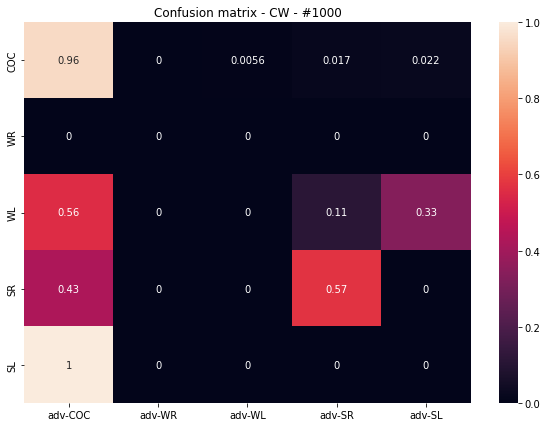

In [100]:
df_cmat = pd.DataFrame(ncmat_nf, index = index0, columns = index1)

plt.figure(figsize = (10,7))
sn.heatmap(df_cmat, annot=True)
plt.title("Confusion matrix - CW - #{0}".format(1000))
plt.show()